Titanic Data Set
---

#### Informacije o atributima
---
- Survival - preziveo ili ne
- pclass - Klasa karte (1., 2., 3.)
- sex - pol
- age - godine
- sibsp - broj rodjaka / supruga na titaniku
- parch - broj roditelja / dece na titaniku
- ticket - broj tiketa
- fare - cena karte
- cabin - broj kabine
- embarked - luka na kojoj je usao/la (C = Cherbourg, Q = Queenstown, S = Southampton)
---

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

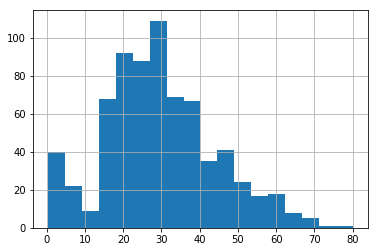

In [4]:
train_df['Age'].hist(bins = 18)

In [5]:
train_df['Age'].isnull().sum() / len(train_df)

0.19865319865319866

Fali dosta informacija o godinama, tako da je nabolje resenje da se nedostajuce vrednosti popune sa srednjom vrednosti

In [6]:
train_df['Cabin'].isnull().sum() / len(train_df)

0.7710437710437711

Vidimo da za atribut Cabin fali 77% informacija, tako da je najbolje resenje da ga ignorisemo u potpunosti

In [7]:
train_df['Embarked'].isnull().sum() / len(train_df)

0.002244668911335578

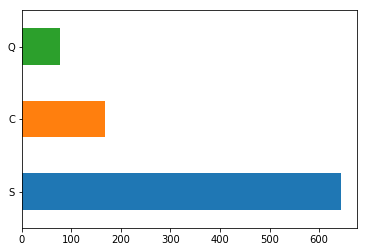

In [8]:
train_df.Embarked.value_counts().plot.barh()

Posto se vecina putnika ukrcala na luci Southampton, nedostajuce vrednosti cemo popuniti sa 'S'

---

## Normalizacija Podataka

In [9]:
def normalizeData(df):
    df['Age'].fillna(df['Age'].median(skipna = True), inplace = True)
    df.drop('Cabin', axis = 1, inplace = True)
    df['Embarked'].fillna('S', inplace = True)
    df.drop('PassengerId', axis=1, inplace=True)
    df.drop('Name', axis=1, inplace=True)
    df.drop('Ticket', axis=1, inplace=True)

    # Kombinujemo SibSp i Parch u jedan atribut koji nazivamo TraveledAlone 
    # (0 - ukoliko nema rodjake, decu, supruga, 1 - ukoliko ima)
    
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['TraveledAlone'] = (df['FamilySize'] == 1).astype(int)
    df.drop('FamilySize', axis=1, inplace=True)
    df.drop('SibSp', axis=1, inplace=True)
    df.drop('Parch', axis=1, inplace=True)
    return df

train_df = normalizeData(train_df)
test_df = normalizeData(test_df)

In [10]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,TraveledAlone
0,0,3,male,22.0,7.2500,S,0
1,1,1,female,38.0,71.2833,C,0
2,1,3,female,26.0,7.9250,S,1
3,1,1,female,35.0,53.1000,S,0
4,0,3,male,35.0,8.0500,S,1


In [11]:
test_df.head()

,Pclass,Sex,Age,Fare,Embarked,TraveledAlone
0,3,male,34.5,7.8292,Q,1
1,3,female,47.0,7.0000,S,0
2,2,male,62.0,9.6875,Q,1
3,3,male,27.0,8.6625,S,1
4,3,female,22.0,12.2875,S,0


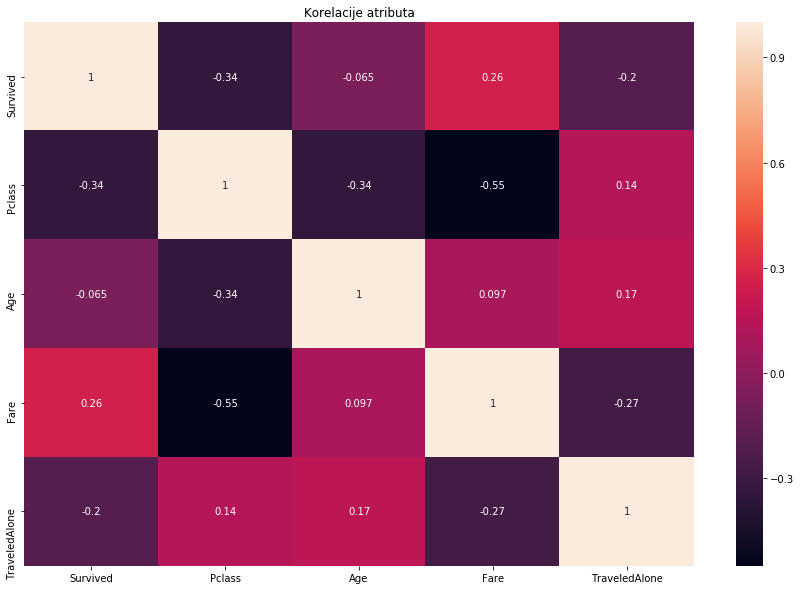

In [12]:
correlations = train_df.corr()

plt.figure(figsize = (15, 10))
sns.heatmap(correlations, annot = True)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('Korelacije atributa')
plt.show()

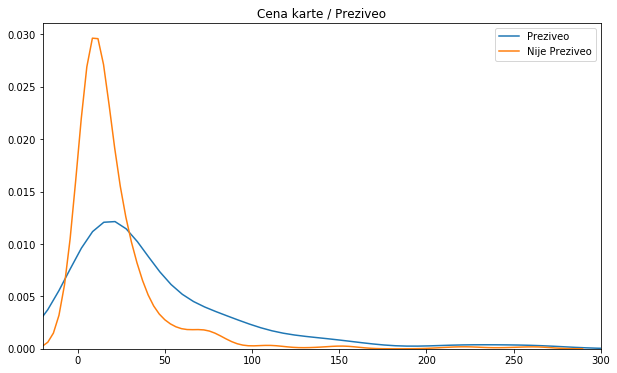

In [13]:
plt.figure(figsize=(10,6))
sns.kdeplot(train_df["Fare"][train_df.Survived == 1])
sns.kdeplot(train_df["Fare"][train_df.Survived == 0])
plt.xlim(-20,300)
plt.legend(['Preziveo', 'Nije Preziveo'])
plt.title('Cena karte / Preziveo')
plt.show()

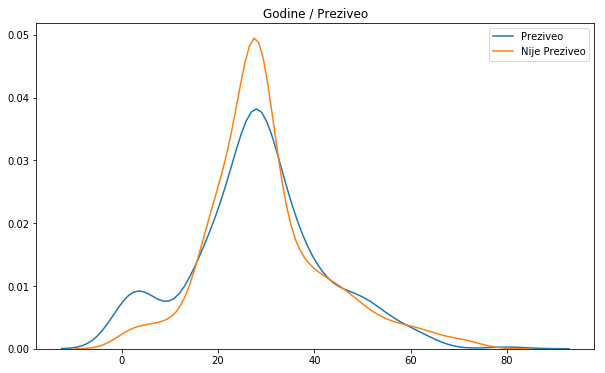

In [14]:
plt.figure(figsize=(10,6))
sns.kdeplot(train_df["Age"][train_df.Survived == 1])
sns.kdeplot(train_df["Age"][train_df.Survived == 0])
plt.legend(['Preziveo', 'Nije Preziveo'])
plt.title('Godine / Preziveo')
plt.show()

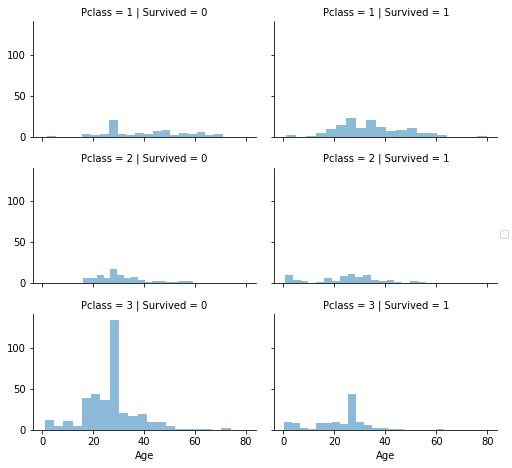

In [15]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

c:\program files\python36\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


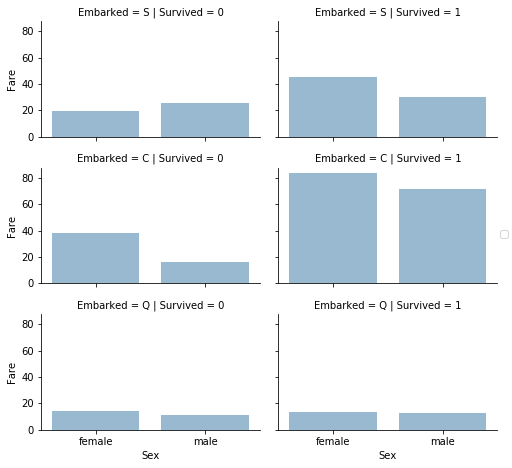

In [16]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

### Priprema za trening

In [17]:
survived = pd.factorize(train_df['Survived'])[0]
survived_label = train_df['Survived']
train_df = train_df.drop('Survived', axis = 1)

cat_features = [[feature, .0] for feature in list(train_df.select_dtypes(object).columns)]
num_features = [[feature, .0] for feature in list(train_df.select_dtypes(exclude = object).columns)]

train_df = pd.get_dummies(train_df, columns = train_df.select_dtypes(object).columns)
train_df.drop('Sex_female', axis = 1, inplace = True)

test_df_original = test_df
test_df = pd.get_dummies(test_df, columns = test_df.select_dtypes(object).columns)
test_df.drop('Sex_female', axis = 1, inplace = True)

pd.concat([test_df, train_df]).head()

,Pclass,Age,Fare,TraveledAlone,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,7.8292,1,1,0,1,0
1,3,47.0,7.0000,0,0,0,0,1
2,2,62.0,9.6875,1,1,0,1,0
3,3,27.0,8.6625,1,1,0,0,1
4,3,22.0,12.2875,0,0,0,0,1


In [18]:
survived[0:5]

array([0, 1, 1, 1, 0], dtype=int64)

## Trening

Text(0,0.5,'stopa greske')

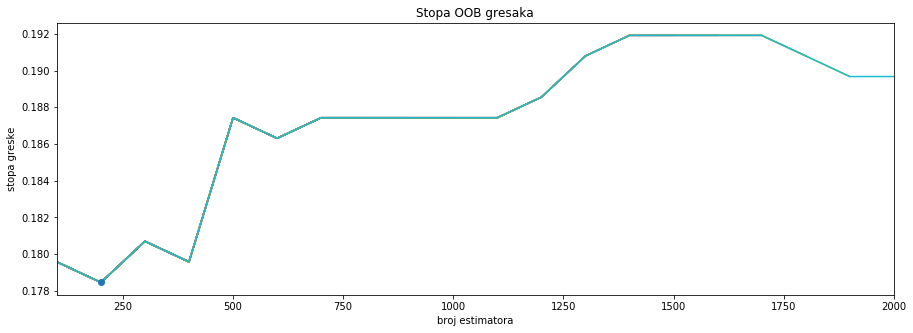

In [19]:
clf = RandomForestClassifier(warm_start = True, oob_score = True)
min_estimators = 100
max_estimators = 2000

oob_errors = []
min_oob_error = 1.0
min_oob_estimator = min_estimators

plt.figure(figsize = (15, 5))
for index in range(min_estimators, max_estimators + 1, 100):
    clf.set_params(n_estimators = index)
    clf.fit(train_df, survived)
    
    oob_error = 1 - clf.oob_score_
    oob_errors.append((index, oob_error))
    
    if (oob_error < min_oob_error):
        min_oob_error = oob_error
        min_oob_estimator = index
        importances = clf.feature_importances_

    xoob, yoob = zip(*oob_errors)
    plt.plot(xoob, yoob)
    
plt.plot(min_oob_estimator, min_oob_error, 'o')
plt.xlim(min_estimators, max_estimators)
plt.title('Stopa OOB gresaka')
plt.xlabel('broj estimatora')
plt.ylabel('stopa greske')

Text(0,0.5,'vaznost')

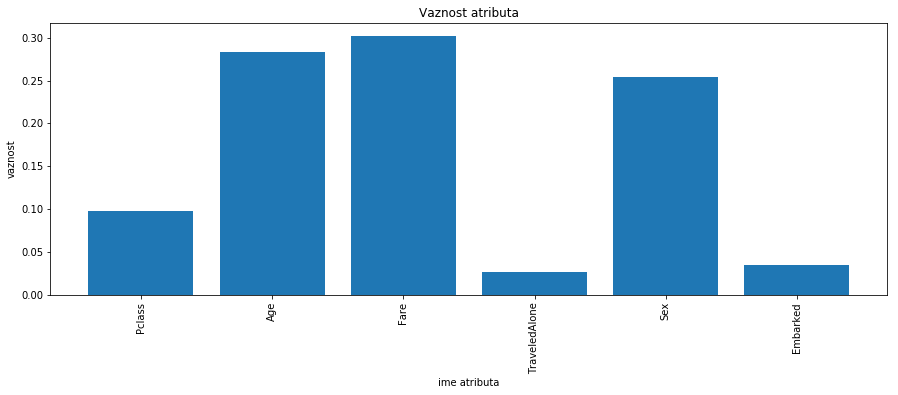

In [20]:
index, cat_feature_index, num_feature_index = (0,) * 3
last_cat_feature = cat_features[0][0]

for feature in list(train_df):
    if feature.startswith(tuple(cat_feature.rsplit('_', 1)[0] for cat_feature, importance in cat_features)):
        if not feature.startswith(last_cat_feature):
            last_cat_feature = feature.rsplit('_', 1)[0]
            cat_feature_index += 1
                
        cat_features[cat_feature_index][1] += importances[index]
    else:
        num_features[num_feature_index][1] = importances[index]
        num_feature_index += 1
            
    index += 1
        
feature_importances = num_features + cat_features
    
plt.figure(figsize = (15, 5))
xfi, yfi = zip(*feature_importances)
plt.bar(xfi, yfi)
plt.xticks(rotation = 90)
plt.title('Vaznost atributa')
plt.xlabel('ime atributa')
plt.ylabel('vaznost')

In [21]:
test_survived = clf.predict(test_df)
test_df_original['Survived'] = test_survived
test_df_original.loc[test_df_original['Survived'] == 1].head(10)

,Pclass,Sex,Age,Fare,Embarked,TraveledAlone,Survived
3,3,male,27.0,8.6625,S,1,1
4,3,female,22.0,12.2875,S,0,1
8,3,female,18.0,7.2292,C,1,1
12,1,female,23.0,82.2667,S,0,1
14,1,female,47.0,61.1750,S,0,1
15,2,female,24.0,27.7208,C,0,1
17,3,male,21.0,7.2250,C,1,1
19,3,female,45.0,7.2250,C,1,1
21,3,male,9.0,3.1708,S,0,1
22,1,female,27.0,31.6833,S,1,1
